In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [6]:
# Import DID_deaths.dta
df = pd.read_stata('DID_deaths.dta')

# Add new column 'legal' to df with value 0 or value 1 if 'state_name' is 'Alabama' and 'year' is >= 1975
df['legal'] = np.where((df['state_name'] == 'Alabama') & (df['year'] >= 1975), 1, 0)

# Print the first 5 rows of df
df.head()

,state_name,year,mrate,legal
0,Alabama,1970,44.791061,0
1,Alabama,1971,43.962112,0
2,Alabama,1972,35.823032,0
3,Alabama,1973,30.016945,0
4,Alabama,1974,35.073116,0


# #13

**Temporal Difference:**<br>

This refers to the difference over time, specifically before and after the treatment or intervention. In our case, the change in the Minimum Legal Drinking Age (MLDA) from 21 to 19 in Alabama in 1975 is the treatment, and the years before and after this change represent the temporal difference.

**Geographical Difference:**<br>

This refers to the difference between the treatment group and the control group, which, in this case, is the difference between Alabama (where the MLDA was reduced to 19) and Arkansas (where the MLDA remained at 21). This geographical difference helps control for any unobserved time-invariant factors that may affect the outcome variable.

# #14

$$\hat{\beta^{}}^{DID} = (\bar{Y}^{treatment, after} + \bar{Y}^{treatment, before}) - (\bar{Y}^{control, after} + \bar{Y}^{control, before}) = \bigtriangleup \bar{Y}^{treatment} - \bigtriangleup \bar{Y}^{control}

The treatment group is Alabama (MLDA changed to 19). <br>
The control group is Arkansas (MLDA remained at 21).

# #15

The parallel trend assumption in the context of difference-in-difference (DID) analysis assumes that, in the absence of treatment, the average treatment and control groups would have followed parallel trends over time. This means that any differences in the outcomes between the two groups before the treatment are due to time-invariant factors and not the treatment itself.

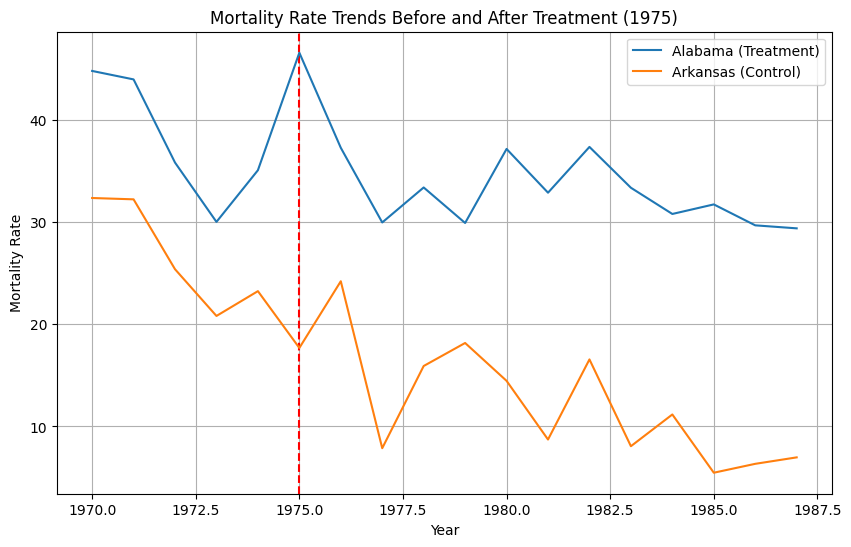

In [7]:

# Subset data for Alabama and Arkansas
alabama_data = df.loc[df['state_name'] == 'Alabama']
arkansas_data = df.loc[df['state_name'] == 'Arkansas']

# Plot trends
plt.figure(figsize=(10, 6))
plt.axvline(x=1975, color='red', linestyle='--')
plt.plot(alabama_data['year'], alabama_data['mrate'], label='Alabama (Treatment)')
plt.plot(arkansas_data['year'], arkansas_data['mrate'], label='Arkansas (Control)')
plt.title('Mortality Rate Trends Before and After Treatment (1975)')
plt.xlabel('Year')
plt.ylabel('Mortality Rate')
plt.legend()
plt.grid()
plt.show()


# #16

$$mrate_{it} = \alpha + \beta\ast Treatment + \gamma\ast Post + \delta\ast (Treatment_{i}*Post_{t}) + \epsilon_{it}

In [34]:

# Create dummy variables for treatment and post-treatment
df['Treat'] = (df['state_name'] == 'Alabama').astype(int)
df['Post'] = (df['year'] >= 1975).astype(int)

# Create an interaction term
df['Treat_Post'] = df['Treat'] * df['Post']

# Specify the regression equation
X = df[['Treat', 'Post', 'Treat_Post']]
X = sm.add_constant(X)  # Add a constant term for the intercept
y = df['mrate']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print regression results
print(model.summary())

# Add a new column 'Predicted' to df with predicted values from the regression model
df['Predicted'] = model.predict(X)


                            OLS Regression Results                            
Dep. Variable:                  mrate   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     43.64
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           2.05e-11
Time:                        14:49:59   Log-Likelihood:                -110.04
No. Observations:                  36   AIC:                             228.1
Df Residuals:                      32   BIC:                             234.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.8037      2.440     10.985      0.0

**Constant (Intercept):**<br> The constant term (const) is  26.8037, indicating the estimated baseline mortality rate when all other variables are zero. In this context, it represents the estimated mortality rate in the control group (Arkansas) in the pre-treatment period.

**Treat (Alabama vs. Arkansas):**<br> The coefficient for Treat is 11.1296. This suggests that, on average, the mortality rate in Alabama (the treatment group) is expected to be 16.3543 units higher than in Arkansas (the control group) in the pre-treatment period.

**Post (After vs. Before):**<br> The coefficient for Post is -14.3732. This implies that, on average, there is a decrease of 14.3732 units in the mortality rate in both Alabama and Arkansas in the post-treatment period compared to the pre-treatment period.

**Treat_Post (Interaction Term):**<br> The coefficient for Treat_Post is 10.2427. This represents the estimated difference-in-difference (DID) effect. In other words, it suggests that, on average, the mortality rate in Alabama experienced an additional increase of 10.2427 units compared to Arkansas due to the change in the Minimum Legal Drinking Age (MLDA) from 21 to 19.



# #17

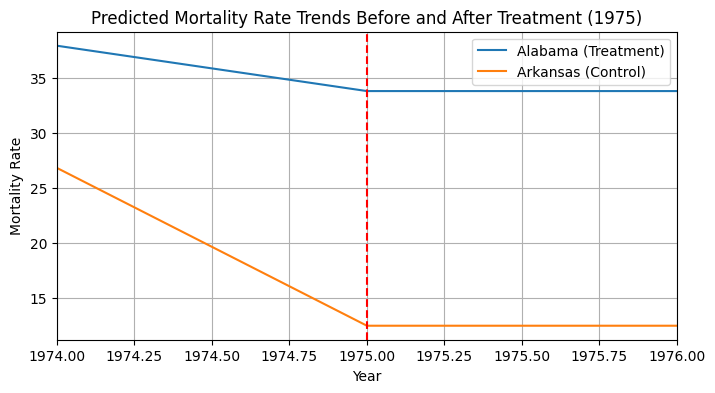

In [31]:
# Plot 'Predicted' for 'Alabama' and 'Arkansas' against 'year'
plt.figure(figsize=(8, 4))
plt.plot(df.loc[df['state_name'] == 'Alabama', 'year'], df.loc[df['state_name'] == 'Alabama', 'Predicted'], label='Alabama (Treatment)')
plt.plot(df.loc[df['state_name'] == 'Arkansas', 'year'], df.loc[df['state_name'] == 'Arkansas', 'Predicted'], label='Arkansas (Control)')
plt.xlim(1974, 1976)
plt.axvline(x=1975, color='red', linestyle='--')
plt.title('Predicted Mortality Rate Trends Before and After Treatment (1975)')
plt.xlabel('Year')
plt.ylabel('Mortality Rate')
plt.legend()
plt.grid()
plt.show()

As we can read from the graph, mortality in Alabama and Arkansas have similar trends pre policy change in 1975. Post policy change in 1975, mortality in Arkansas decreases significantly more than pre. A possible reason for this could be that people who are 19-20 years old, move to Alabama because of their lower MLDA. As we can see from the graph over mortality in Alabama, the decrease in mortality slows down, probably because people (19-20 years old) have moved there, from other states, more young people = higher mortality. FÖRKLARA MER KRING MORTALITY, det är per 100k population.

# #18

Adding information on the mortality rates specifically for the age group 15-17 can enhance the precision and reliability of our analysis, providing a more nuanced understanding of the impact of the Minimum Legal Drinking Age (MLDA) change. Here's a potential regression set-up:

$$mrate_{it} = \alpha + \beta\ast Treatment + \gamma\ast Post + \delta\ast (Treatment_{i}*Post_{t}) + \theta*Teen_{it} + \epsilon_{it} 

**Results Supporting Original Findings:**<br>

If the coefficient for Teen is statistically significant and positive, it suggests that the MLDA change had a different impact on the mortality rate for the age group 15-17 in Alabama compared to Arkansas. This would provide additional support for our original findings.

**Results Contradicting Original Findings:**<br>

If the coefficient for Teen is statistically significant and negative, it would imply that the MLDA change had a mitigating effect on the mortality rate for the age group 15-17 in Alabama compared to Arkansas. This could pose a challenge to the original interpretation, suggesting that the MLDA change may have had a protective effect on the younger age group.

**No Significant Effect:**<br>

If the coefficient for Teen is not statistically significant, it suggests that there is no significant difference in the impact of the MLDA change on the mortality rate for the age group 15-17 between Alabama and Arkansas. In this case, the original findings remain unchanged.